In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#필요한 lib으로 한번만 하고, jupyter환경에선 다신 실행 안하셔도되고, colab에선 실행할 때마다 해주심 됩니다.
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 5.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=4b39406167499963b4746aa8a833c950330c8b017d379b10bf84c134619035bd
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.3 MB/s eta 0:00:00


In [5]:
# plt.style.available

In [6]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn-v0_8') # 이 위에 코드를 실행하면 여러 테마가 있으니 마음껏 바꾸셔도 됩니다.
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

from dateutil import tz

import shap
import skimage


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.options.display.max_columns = 400
pd.set_option('display.max_colwidth', None)

<Figure size 1600x800 with 0 Axes>

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lending_club/lending_club_2020_train.csv')
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,2 years,MORTGAGE,45000.0,Verified,Dec-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=124989905,debt_consolidation,Debt consolidation,554xx,MN,8.67,1.0,Sep-2005,755.0,759.0,0.0,22.0,NaN,14.0,0.0,3090.0,14%,36.0,w,0.00,0.00,6718.840000,6718.84,6000.00,718.84,0.00,0.00,0.0000,Apr-2020,1835.06,NaN,Apr-2020,764.0,760.0,0.0,NaN,1.0,Joint App,100500.0,10.20,Verified,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,1.0,0.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,NaN,3.0,NaN,0.0,1.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,3926.0,555.0,559.0,Sep-2005,0.0,0.0,10.0,NaN,10.0,4.0,1.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,2 years,RENT,94000.0,Source Verified,Sep-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=139665484,credit_card,Credit card refinancing,085xx,NJ,17.41,0.0,Dec-2002,715.0,719.0,2.0,NaN,NaN,6.0,0.0,24640.0,35.4%,8.0,w,25993.32,25993.32,16430.860000,16430.86,9006.68,7424.18,0.00,0.00,0.0000,May-2020,822.95,Jun-2020,May-2020,754.0,750.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,58284.0,1.0,1.0,1.0,1.0,5.0,33644.0,96.0,0.0,0.0,8542.0,56.0,69600.0,1.0,0.0,2.0,1.0,9714.0,44960.0,35.4,0.0,0.0,30.0,154.0,46.0,5.0,0.0,46.0,NaN,5.0,NaN,0.0,4.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,104863.0,58284.0,69600.0,35000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82

In [8]:
column_types = df.dtypes

# float와 object로 나누기
float_columns = []
object_columns = []
for column_name, dtype in column_types.items():
    if dtype == 'float':
        float_columns.append(column_name)
    elif dtype == 'object':
        object_columns.append(column_name)

print("Float 열:", float_columns)
print("Object 열:", object_columns)

Float 열: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_

우선 float자료형으로 밑에 모델을 돌려볼 예정

In [9]:
# 타겟 변수 추가.
float_columns.append('loan_status')

In [10]:
df = df[float_columns]

In [11]:
# 결측치 우선 0으로 채움
df.fillna(0, inplace = True)

In [12]:
# 결측치 있나 확인
df.isnull().sum()

loan_amnt                                     0
funded_amnt                                   0
funded_amnt_inv                               0
installment                                   0
annual_inc                                    0
dti                                           0
delinq_2yrs                                   0
fico_range_low                                0
fico_range_high                               0
inq_last_6mths                                0
mths_since_last_delinq                        0
mths_since_last_record                        0
open_acc                                      0
pub_rec                                       0
revol_bal                                     0
total_acc                                     0
out_prncp                                     0
out_prncp_inv                                 0
total_pymnt                                   0
total_pymnt_inv                               0
total_rec_prncp                         

In [13]:
stat_list = list(df['loan_status'].unique())

In [14]:
stat_list

['Fully Paid',
 'Current',
 'Charged Off',
 'Late (16-30 days)',
 'Late (31-120 days)',
 'In Grace Period',
 'Issued',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Default',
 0]

In [15]:
not_deliq = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']

In [16]:
loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    if stat in not_deliq:
        target.append(1)
    else:
        target.append(0)
print(len(target))
print(len(df))

1755295
1755295


In [17]:
df['target'] = target

In [18]:
df['target']

0          1
1          1
2          0
3          1
4          1
          ..
1755290    0
1755291    1
1755292    1
1755293    1
1755294    1
Name: target, Length: 1755295, dtype: int64

In [19]:
df = df.drop(columns = 'loan_status')

In [20]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,target
0,6000.0,6000.0,6000.0,187.94,45000.0,8.67,1.0,755.0,759.0,0.0,22.0,0.0,14.0,0.0,3090.0,36.0,0.00,0.00,6718.840000,6718.84,6000.00,718.84,0.00,0.00,0.0000,1835.06,764.0,760.0,0.0,0.0,1.0,100500.0,10.20,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,1.0,0.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,3926.0,555.0,559.0,0.0,0.0,10.0,0.0,10.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,1
1,35000.0,35000.0,35000.0,822.95,94000.0,17.41,0.0,715.0,719.0,2.0,0.0,0.0,6.0,0.0,24640.0,8.0,25993.32,25993.32,16430.860000,16430.86,9006.68,7424.18,0.00,0.00,0.0000,822.95,754.0,750.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,58284.0,1.0,1.0,1.0,1.0,5.0,33644.0,96.0,0.0,0.0,8542.0,56.0,69600.0,1.0,0.0,2.0,1.0,9714.0,44960.0,35.4,0.0,0.0,30.0,154.0,46.0,5.0,0.0,46.0,0.0,5.0,0.0,0.0,4.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,104863.0,58284.0,69600.0,35000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,1
2,23200.0,23200.0,23200.0,680.82,110000.0,34.70,1.0,670.0,674.0,1.0,10.0,0.0,24.0,0.0,16909.0,60.0,0.00,0.00,8599.680000,8599.68,1030.43,2309.25,0.00,5260.00,946.8000,680.82,639.0,635.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,4698.0,85.0,30255.0,4.0,3.0,7.0,8.0,25264.0,6014.0,70.4,0.0,0.0,126.0,277.0,6.0,6.0,2.0,7.0,10.0,0.0,10.0,0.0,8.0,10.0,8.0,14.0,36.0,12.0,22.0,10.0,24.0,0.0,0.0,0.0,5.0,94.8,37.5,0.0,0.0,650914.0,294461.0,20300.0,291465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0
3,4500.0,4500.0,4500.0,145.06,35000.0,14.95,1.0,675.0,679.0,1.0,22.0,0.0,22.0,0.0,6435.0,32.0,982.41,982.41,4204.260000,4204.26,3517.59,686.67,0.00,0.00,0.0000,145.06,669.0,665.0,1.0,22.0,1.0,0.0,0.00,0.0,0.0,6435.0,2.0,0.0,0.0,0.0,26.0,0.0,0.0,6.0,12.0,3040.0,12.0,53000.0,0.0,0.0,4.0,12.0,293.0,25751.0,16.1,0.0,0.0,127.0,265.0,2.0,2.0,0.0,8.0,0.0,2.0,0.0,1.0,6.0,13.0,9.0,11.0,4.0,22.0,27.0,14.0,22.0,0.0,0.0,1.0,6.0,96.8,22.2,0.0,0.0,53000.0,6435.0,30700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,1
4,15000.0,15000.0,

In [21]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [22]:
df_train.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,target
count,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1053177.0,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06
mean,1.535042e+04,1.534633e+04,1.533145e+04,4.520167e+02,7.994741e+04,1.927715e+01,2.891366e-01,7.005539e+02,7.045541e+02,5.547700e-01,1.658305e+01,1.091731e+01,1.167912e+01,1.762999e-01,1.693749e+04,2.402007e+01,4.033125e+03,4.032548e+03,1.257369e+04,1.255888e+04,9.918217e+03,2.483824e+03,1.765855e+00,1.698854e+02,2.903722e+01,3.477322e+03,6.904397e+02,6.779534e+02,1.770737e-02,1.100575e+01,1.0,9.421730e+03,1.405481e+00,3.364107e-03,2.080650e+02,1.419552e+05,6.555052e-01,1.988854e+00,4.923522e-01,1.127998e+00,1.392663e+01,2.591996e+04,4.168138e+01,8.806307e-01,1.859148e+00,4.231216e+03,3.958377e+01,3.546175e+04,7.551171e-01,1.067805e+00,1.410697e+00,4.411266e+00,1.338677e+04,1.234557e+04,5.426255e+01,8.019545e-03,9.818222e+00,1.191385e+02,1.753456e+02,1.412357e+01,8.145947e+00,1.485055e+00,2.438638e+01,8.721924e+00,6.199204e+00,1.145

In [23]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()


In [24]:
x_data = list(df_train.columns)
x_data.remove('target')
x_data

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeof

In [25]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# 하나하나 선택해도 되지만, 필요없는 columns은 진작에 삭제해버려도 좋을듯
# Target은 Survived

NgBoost Hyperparameter list up
https://github.com/stanfordmlgroup/ngboost/blob/51a299197ae77dff88826156edf386313201d99b/ngboost/api.py#L21

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

xgboost = Train(XGBClassifier(n_estimators=50, max_depth=7), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=7, num_leaves = 70), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=7), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:39

Prediction time: 
Execution Time: 00:00:01
[LightGBM] [Info] Number of positive: 911019, number of negative: 142158
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.694273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13941
[LightGBM] [Info] Number of data points in the train set: 1053177, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.865020 -> initscore=1.857625
[LightGBM] [Info] Start training from score 1.857625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [28]:
models = [
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb),
]

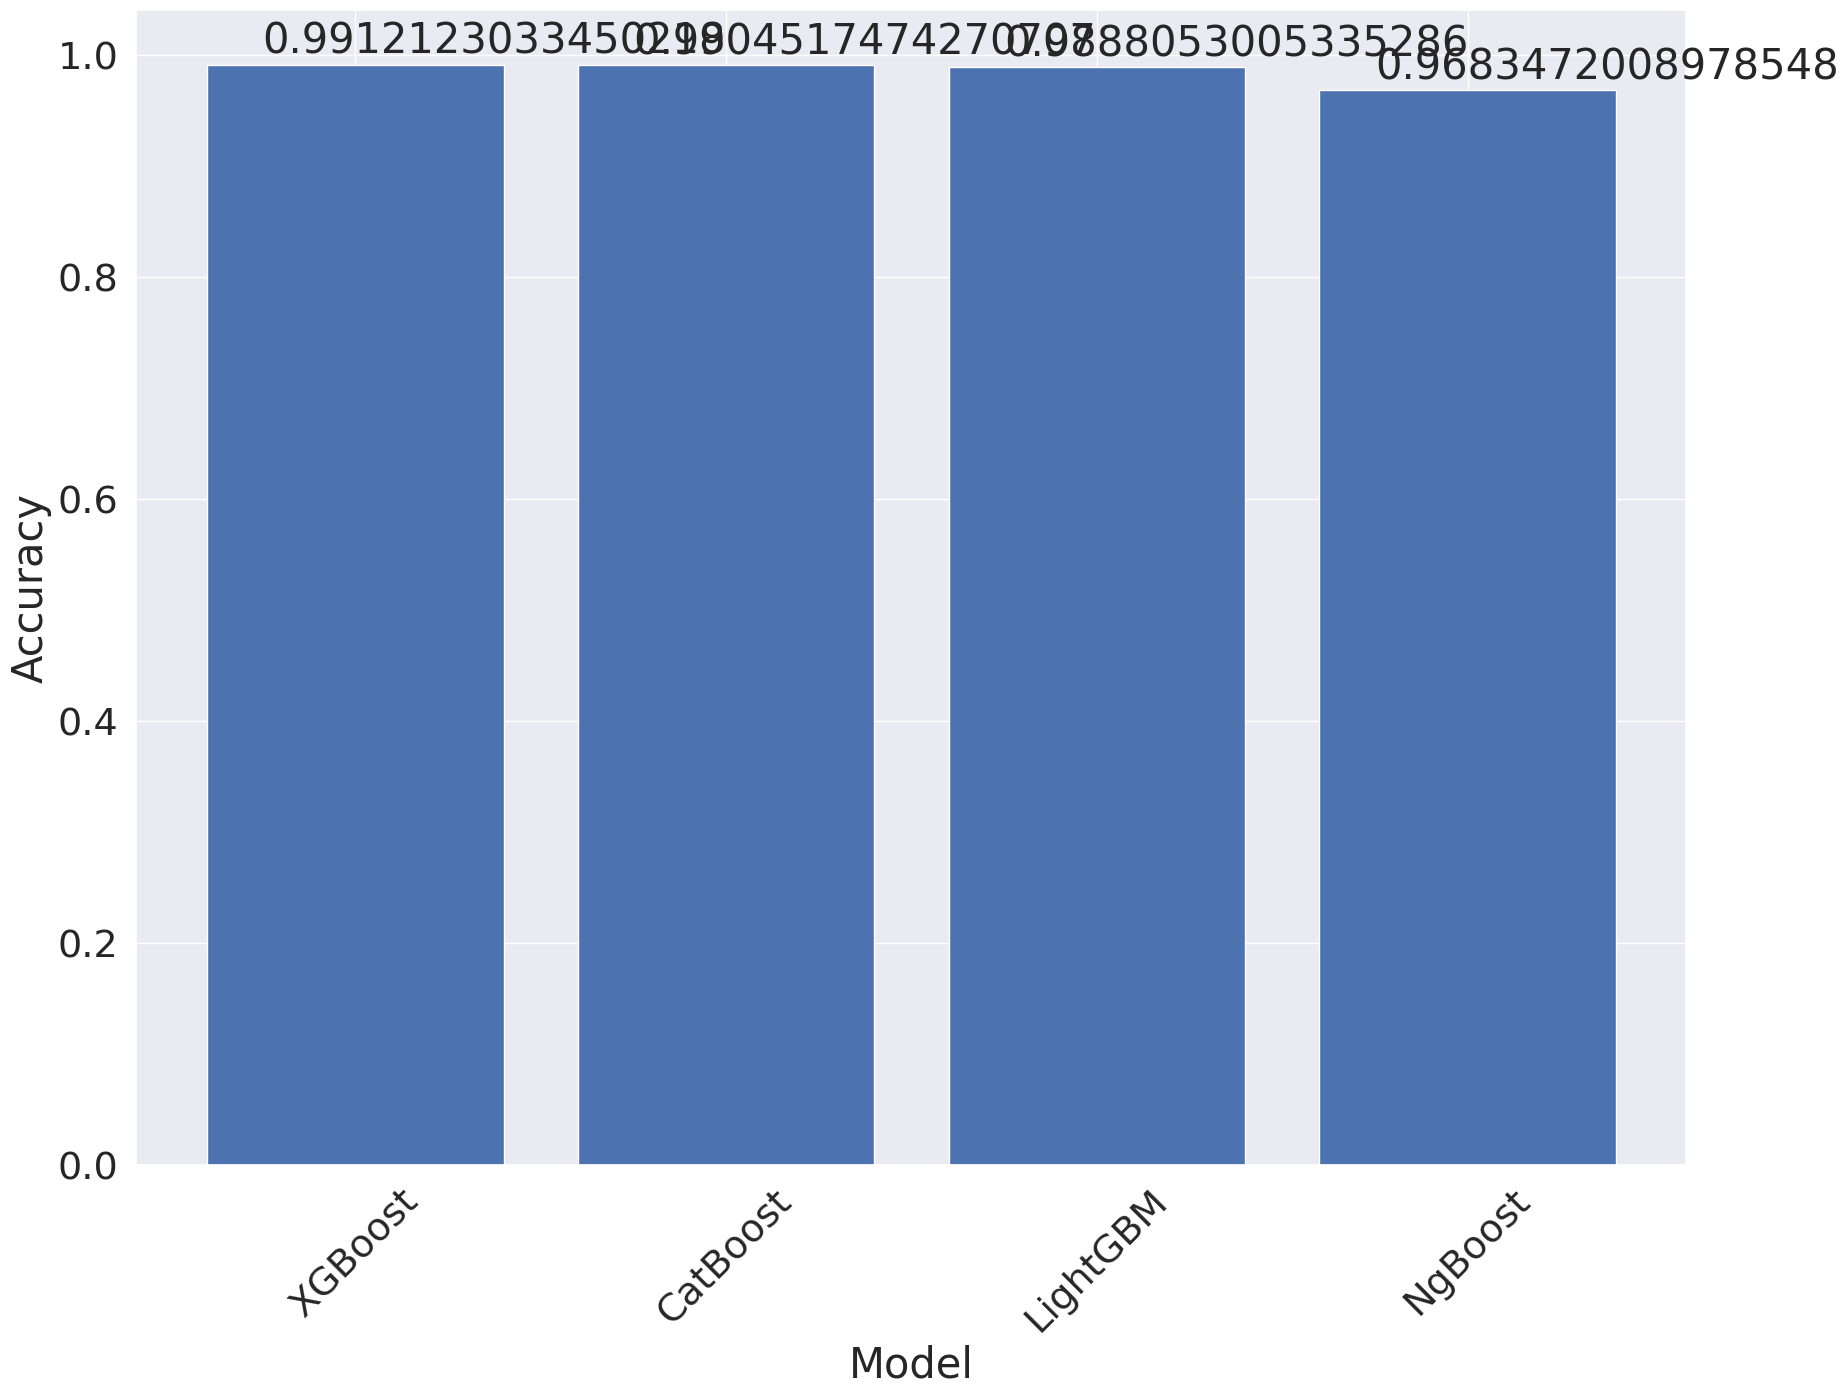

In [29]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

## Shap 추가
출처 : https://todayisbetterthanyesterday.tistory.com/57

In [30]:
explainer = shap.TreeExplainer(lgb) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [31]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)
